In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Introduction
In this Notebook we show how to build a multiclass classifier, by:
 - applying simple pre-processing steps
 - trying different baseline algorithms
 - optimizing the hyperparameters of XGBoost
 
In the pre-processing steps, we convert the non numerical features using the LabelEncoding for most of the columns, i.e.for
the columns that have only two possible values or more than two sortable values. The only column that has not these characteristic is the MTRANS, where we apply the one-hot encoding.

Then we do some data exploration, analyzing the correlation between numerical features and labels, the distribution of train and test data, the distribution of labels, etc...

Then we train 4 different baseline classifier: RandomForest, GradientBoosting, LightGBM and XGBoost, XGBoost shows the best performance, so we decide to optimize
its hyperparameters by using the framework Optuna.

Finally we perfrom the predictions in two ways:

 - using all the training data.
 - using 5-fold stratified splitting and computing the average predicted probabilities out of 5


## 1. import data
We import the data and we create two subsets:
 - one with numerical data
 - one with categorical data

In [41]:
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', index_col = 0)
df.head()
df["BMI"] = df["Weight"]/(df["Height"]*df["Height"])
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
id,,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,36.587084
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.099278
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,31.889841


['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


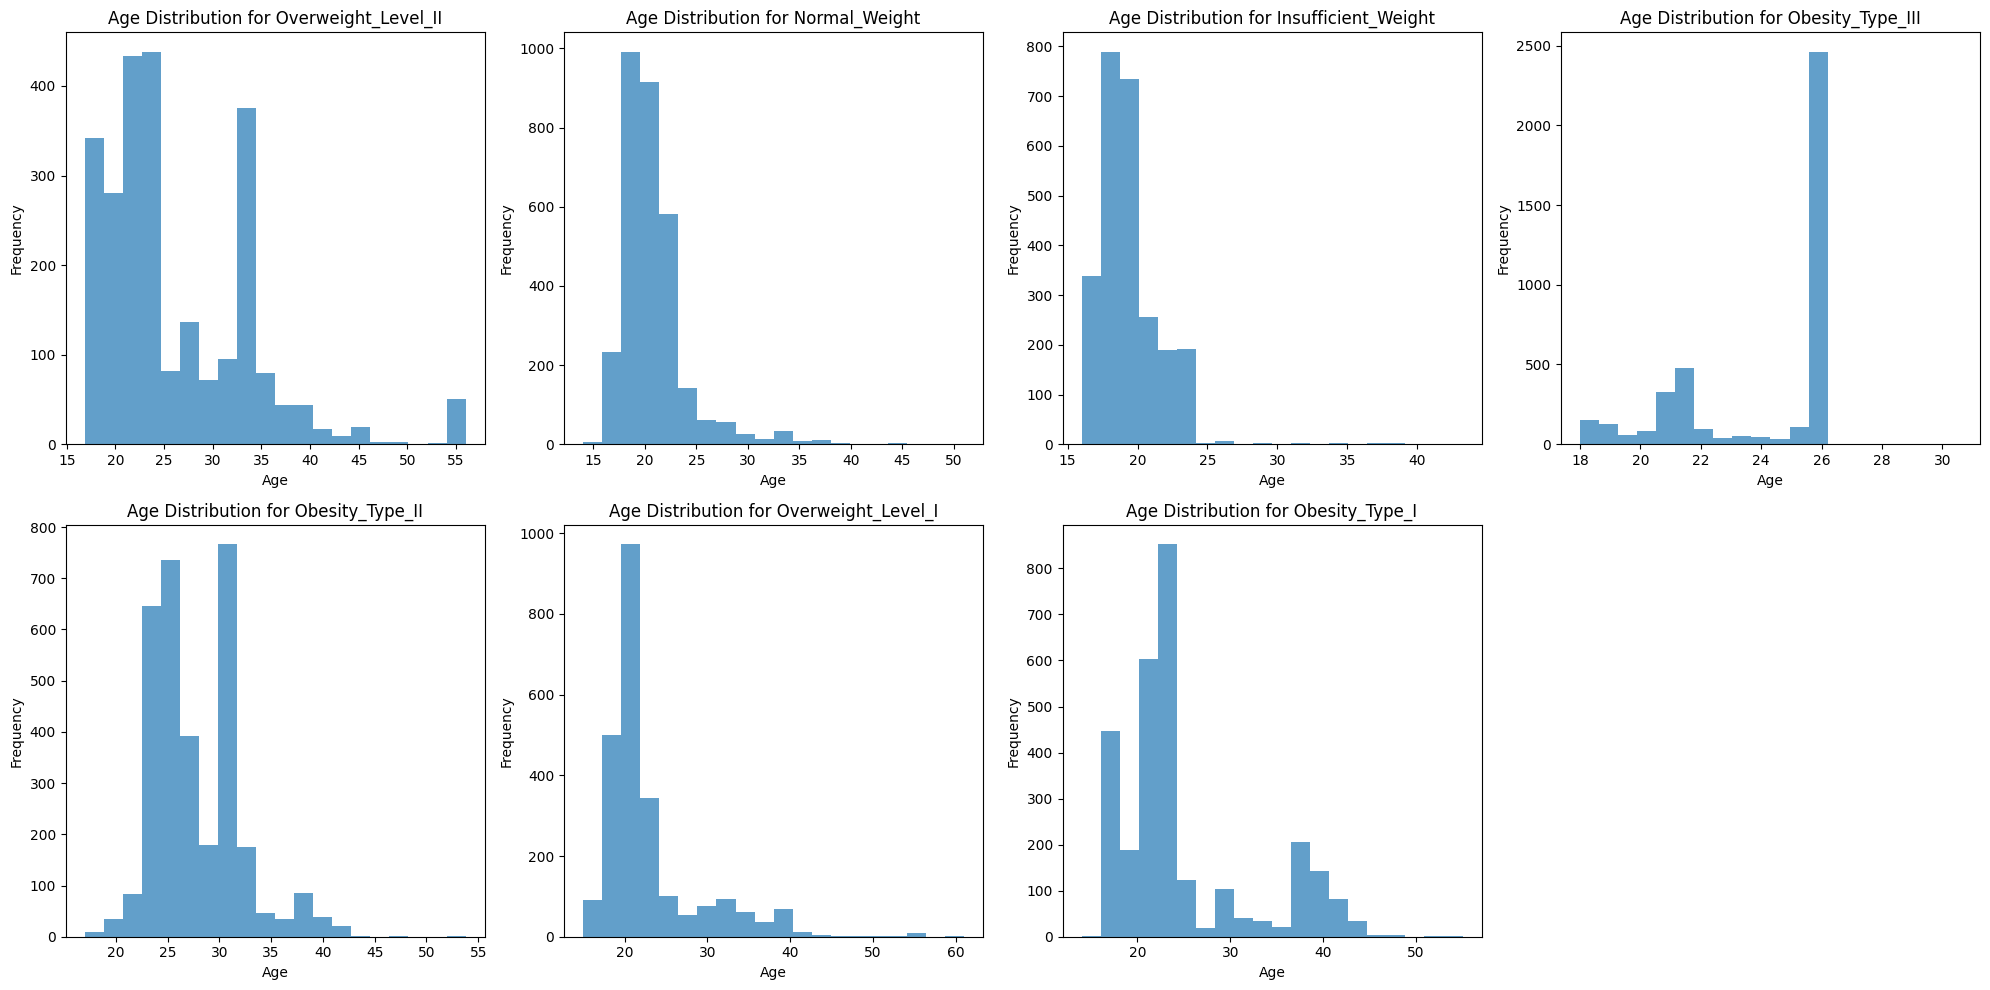

In [42]:
# 각 비만도 별로 나이 분포대 시각화
unique_categories = df['NObeyesdad'].unique()
print(unique_categories)
plt.figure(figsize=(20,10))

for i, category in enumerate(unique_categories, start=1):
    category_data = df[df['NObeyesdad'] == category]['Age']
    plt.subplot(2, 4, i)
    plt.hist(category_data, bins=20, alpha=0.7)
    plt.title(f'Age Distribution for {category}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    

plt.tight_layout()    
plt.show()

# train_data 결측치 없음을 확인.
df.isnull().sum()

In particular we can deduct that:

- 'Gender', 'Age', 'Height', 'Weight' are physical attributes
- 'family_history_with_overweight' points out to familiarity with obesity
- FAVC = Frequent consumption of high caloric food
- FCVC = Frequency of consumption of vegetables
- NCP = Number of main meals
- CAEC = Consumption of food between meals
- SMOKE = tobacco usage
- CH20 = Consumption of water daily
- SCC = Calories consumption monitoring
- FAF = Physical activity frequency
- TUE = Time using technology devices
-CALC = Consumption of alcohol
MTRANS = Transportation used

In [43]:
# train 데이터 X(features) 독립변수, y(labels) 종속변수 분리
labels = pd.DataFrame(df['NObeyesdad'])
features = df.drop('NObeyesdad', axis=1)

## 2.Data exploration and pre-processing

### Numerical DataFrame

In [44]:
# 독립 변수 중 숫자형 칼럼 분리. df_numerical은 정규화 하기 전의 숫자형 칼럼.
mask_numeric = features.dtypes == float
df_numerical = features.loc[:, mask_numeric]

df_numerical

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
id,,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,28.259565
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,23.422091
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,17.126706
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,44.855798
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,25.599151
...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,36.587084
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,17.099278
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,31.889841


In [45]:
## 정규화 전 숫자형 칼럼의 평균과 분산
print('feature들의 평균 값')
print(df_numerical.mean())
print('\nfeature들의 분산 값')
print(df_numerical.var())

feature들의 평균 값
Age       23.841804
Height     1.700245
Weight    87.887768
FCVC       2.445908
NCP        2.761332
CH2O       2.029418
FAF        0.981747
TUE        0.616756
BMI       30.241842
dtype: float64

feature들의 분산 값
Age        32.354163
Height      0.007623
Weight    695.875017
FCVC        0.284322
NCP         0.497553
CH2O        0.370232
FAF         0.702750
TUE         0.362541
BMI        69.454421
dtype: float64


In [46]:
# 스케일 시작 -> StandardScaler 사용 -> TEST 1. 정규화 하고 안하고의 정확도 차이. 2. Standard vs min_max
from sklearn.preprocessing import StandardScaler


#객체 생성
scaler = StandardScaler()
scaler.fit(df_numerical)

numerical_scaled = scaler.transform(df_numerical)
df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

print('feature들의 평균 값')
print(df_numerical_scaled.mean())
print('\nfeature들의 분산 값')
print(df_numerical_scaled.var())


feature들의 평균 값
Age       1.889486e-16
Height   -1.107677e-15
Weight   -1.297310e-16
FCVC      1.095354e-16
NCP       1.762836e-17
CH2O     -2.931785e-16
FAF       3.902200e-17
TUE       1.328117e-16
BMI       1.937408e-16
dtype: float64

feature들의 분산 값
Age       1.000048
Height    1.000048
Weight    1.000048
FCVC      1.000048
NCP       1.000048
CH2O      1.000048
FAF       1.000048
TUE       1.000048
BMI       1.000048
dtype: float64


In [47]:
# 이상치 파악 -> 이상치가 있긴 하지만 의미 있는 이상치이기에 제거하지 않음
import pandas as pd

# 각 숫자형 변수의 이상치 개수 계산
outliers = pd.DataFrame(index=df_numerical.columns, columns=["Has Outliers", "Outlier Count"])

for column in df_numerical.columns:
    Q1 = df_numerical[column].quantile(0.25)
    Q3 = df_numerical[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_count = ((df_numerical[column] < lower_bound) | (df_numerical[column] > upper_bound)).sum()
    
    outliers.loc[column, "Has Outliers"] = outlier_count > 0
    outliers.loc[column, "Outlier Count"] = outlier_count

print(outliers)


       Has Outliers Outlier Count
Age            True          1074
Height         True             4
Weight        False             0
FCVC          False             0
NCP            True          6052
CH2O          False             0
FAF           False             0
TUE           False             0
BMI           False             0


### Categorical DataFrame

In [48]:
# 범주형 칼럼만 추출하여 각 컬럼마다 원소 개수 확인
mask_categorical = features.dtypes != float
df_categorical = features.loc[:, mask_categorical]

for i in range(df_categorical.shape[1]):
    print(df_categorical.iloc[:, i].value_counts())


Gender
Female    10422
Male      10336
Name: count, dtype: int64
family_history_with_overweight
yes    17014
no      3744
Name: count, dtype: int64
FAVC
yes    18982
no      1776
Name: count, dtype: int64
CAEC
Sometimes     17529
Frequently     2472
Always          478
no              279
Name: count, dtype: int64
SMOKE
no     20513
yes      245
Name: count, dtype: int64
SCC
no     20071
yes      687
Name: count, dtype: int64
CALC
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64
MTRANS
Public_Transportation    16687
Automobile                3534
Walking                    467
Motorbike                   38
Bike                        32
Name: count, dtype: int64


## Encoding

In [49]:
# 범주형 칼럼 인코딩(Label encoding, one-hot encoding)

df_encoded = df_categorical.copy(deep=True)

# Label encoding
df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
df_encoded['family_history_with_overweight'] = df_encoded['family_history_with_overweight'].map({'no':0, 'yes':1})
df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes': 1, 'Frequently':2, 'Always':3})
# One-Hot encoding
df_onehot = pd.get_dummies(df_categorical['MTRANS']).astype(int)
df_encoded.drop('MTRANS', axis=1, inplace=True)

# concatenate
# one feature of df_encoded is redundant; we can remove it
df_encoded = pd.concat([df_encoded, df_onehot.iloc[:, :]], axis = 1)

df_encoded # 문자 -> 숫자 인코딩

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking
id,,,,,,,,,,,,
0,0,1,1,1,0,0,1,0,0,0,1,0
1,1,1,1,2,0,0,0,1,0,0,0,0
2,1,1,1,1,0,0,0,0,0,0,1,0
3,1,1,1,1,0,0,1,0,0,0,1,0
4,0,1,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0,1,1,1,0,0,1,0,0,0,1,0
20754,0,0,1,2,0,0,1,0,0,0,1,0
20755,0,1,1,1,0,0,0,0,0,0,1,0


### Concatenate all features together

In [50]:
# df_all_features는 스케일과 인코딩이 최종적으로 모두 끝난 독립변수 dataframe
df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

df_all_features

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Gender,...,FAVC,CAEC,SMOKE,SCC,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking
0,0.105699,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438,-0.237862,0,...,1,1,0,0,1,0,0,0,1,0
1,-1.027052,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513,-0.818331,1,...,1,2,0,0,0,1,0,0,0,0
2,-1.027052,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239,-1.573741,1,...,1,1,0,0,0,0,0,0,1,0
3,-0.507929,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455,1.753591,1,...,1,1,0,0,1,0,0,0,1,0
4,1.371197,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111,-0.557096,0,...,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.227725,0.760293,0.996987,0.888355,0.338364,0.201151,0.416056,-0.697686,0.761393,0,...,1,1,0,0,1,0,0,0,1,0
20754,-1.027052,0.111729,-1.436296,1.039171,1.756085,-1.691863,1.214691,0.636513,-1.577032,0,...,1,2,0,0,1,0,0,0,1,0
20755,-0.657669,1.366537,0.670717,-0.071439,0.338364,-0.048349,0.210303,0.966092,0.197750,0,...,1,1,0,0,0,0,0,0,1,0
20756,1.760067,-0.002805,-0.165574,0.422594,-1.119801,0.189694,-1.171141,0.593055,-0.161050,0,...,1,1,0,0,0,1,0,0,0,0


### Define a pre_processing pipeline
Let us summarize all the previous steps into a function, called 'apply_preprocessing'

In [51]:
# 위 전처리 코드를 파이프라인 함수 코드로 만듦 -> test 데이터의 독립변수 전처리할 때 사용할 예정
def apply_preprocessing(data):
    features = data.copy(deep=True)
    # numerical dataframe
    mask_numeric = features.dtypes == float
    df_numerical = features.loc[:, mask_numeric]
    
    # categorical dataframe
    mask_categorical = features.dtypes != float
    df_categorical = features.loc[:, mask_categorical]
    #객체 생성

    numerical_scaled = scaler.transform(df_numerical)
    df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

    # label encoding
    df_encoded = df_categorical.copy(deep=True)
    df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
    df_encoded['family_history_with_overweight'] = df_categorical['family_history_with_overweight'].map({'no':0, 'yes':1})
    df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
    df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
    df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
    df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})

    # one-hot encoding
    df_onehot = pd.get_dummies(df_categorical['MTRANS']).astype(int)
    df_encoded.drop('MTRANS', axis=1, inplace=True)
    
    # one feature of df_encoded is redundant; we can remove it
    df_encoded = pd.concat([df_encoded, df_onehot.iloc[:, :]], axis = 1)
    df_numerical_scaled.reset_index(drop=True, inplace=True)
    df_encoded.reset_index(drop=True, inplace=True)
    # concatenate
    # one feature of df_encoded is redundant; we can remove it
    df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

    
    return df_all_features


### Compare train and test dataset
The train dataset is that one that we will use to train the model. It has labels.
The test dataset will be used to make predictions and submit them to the competition.

In [52]:
# test 데이터를 불러옴. test 데이터 파일 전체가 종속 변수가 됨.
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', index_col = 0)
df_test["BMI"] = df_test["Weight"]/(df_test["Height"]*df_test["Height"])
# 불러온 test를 위에서 만들어놓은 전처리 pipeline 함수 'apply_preprocessing'을 이용하여 인코딩과 스케일 적용
df_test = apply_preprocessing(df_test)

print('Train columns', df_all_features.columns)
print('Test columns', df_test.columns)
print(df_test.head())
assert all(df_test.columns == df_all_features.columns), "Column in train and test dataset must be the same"

Train columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation', 'Walking'],
      dtype='object')
Test columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation', 'Walking'],
      dtype='object')
        Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0  0.537644  1.695675  1.241770  0.924049  0.338364  1.308584 -0.150721   
1 -0.499620 -1.148152 -0.829748 -0.836279 -2.497077  1.595165  0.021775   
2  0.379434 -0.651587  0.898933  1.039171  0.338364  0.973714 -1.171141   
3 -0.503267 -1.685011  0.598259 -0.836279  0.307045  1.244138 -1.057992   
4  0.379434 -0.834373  0.642469  1.039171  0

### Labels

In [53]:
# labels는 train데이터의 종속 변수
labels['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [54]:
# labels의 값을 인코딩 함
labels_encoded = labels.copy(deep=True)

dict_conversion = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}

labels_encoded['NObeyesdad'] = labels_encoded['NObeyesdad'].map(dict_conversion)
labels_encoded.value_counts()


NObeyesdad
6             4046
5             3248
1             3082
4             2910
0             2523
3             2522
2             2427
Name: count, dtype: int64

## 3.Prepare data for machine learning

In [55]:
from sklearn.model_selection import train_test_split


# X는 train 데이터의 독립변수 y는 train 데이터의 종속변수
X = df_all_features.loc[: , ["BMI","NCP","Age", "Height", "Weight", "FCVC", "CH2O", "FAF", "TUE", "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "Automobile", "Bike", "Motorbike", "Public_Transportation"]]
# 머신러닝 모델을 훈련할 때는 대부분의 경우 np.ravel()을 사용하여 타겟 변수를 1차원 배열로 변환하는 것이 안전함.
y = np.ravel(labels_encoded)

# compare train and test data
# X_test는 test 데이터의 독립변수
X_test = df_test.loc[: , ["BMI","NCP","Age", "Height", "Weight", "FCVC", "CH2O", "FAF", "TUE", "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "Automobile", "Bike", "Motorbike", "Public_Transportation"]]
assert all(X_test.columns == X.columns), "Columns of trainging and test data must be the same"

print('Number of samples', len(X))
print('Number of featires', X.shape[1])

# train 데이터를 나눠주어 검증 데이터를 만들어 줌.
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Number of samples 20758
Number of featires 20


## Fit the data with baseline models

In [56]:
# 일단은 4개의 모델을 기본값으로 사용하여 정확도를 측정해본다!
# 그래디언트 부스트, 랜덤, LGBM, XGB 사용
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier(class_weight='balanced')
clf3 = LGBMClassifier(class_weight='balanced')
clf4 = XGBClassifier()

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2275
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 20
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [57]:
# X_train과 X_validation을 사용하여 정확도를 평가하는 함수.
def evaluate_model(clf):
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_validation)
    train_score = np.mean(y_pred_train == y_train)
    validation_score = np.mean(y_pred_test == y_validation)
    
    print('Train score', round(train_score, 3))
    print('Test score', round(validation_score, 3))
    
    if train_score - validation_score > 0.05:
        print('Overfitting detected')
    
    print('=========================================')

In [58]:
print('Random Forest')
evaluate_model(clf2)

print('LightGBM')
evaluate_model(clf3)

print('Gradient Boosting')
evaluate_model(clf1)

print('XGBoost')
evaluate_model(clf4)

Random Forest
Train score 1.0
Test score 0.898
Overfitting detected
LightGBM
Train score 0.983
Test score 0.9
Overfitting detected
Gradient Boosting
Train score 0.921
Test score 0.898
XGBoost
Train score 0.989
Test score 0.901
Overfitting detected


## 5. Hyperparameter tuning
We fine_tune the XGBoost Classifier, LightGBM defined in the previous section, using the optimizer framework called Optuna

In [59]:
# 하이퍼파라미터 튜닝(여기서 XGBoost와 LightGBM 파라미터 튜닝을 한 번에 함 -> 시간 오래 걸림)
import optuna
from sklearn.model_selection import cross_validate

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 4, 10)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0, 1)
    
    print('Training the model with', X.shape[1], 'features')
    
    # XGBoost 
    if trial.suggest_categorical('model', ['xgboost', 'lightgbm']) == 'xgboost':
        params = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'gamma': gamma,
                  'reg_alpha': reg_alpha,
                  'reg_lambda': reg_lambda,
                  'max_depth': max_depth,
                  'min_child_weight': min_child_weight,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'eval_metric':'mlogloss'}

        clf = XGBClassifier(**params)
   
    # LightGBM
    else:
        params = {'learning_rate': learning_rate,
                  'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'lambda_l1': reg_alpha,
                  'lambda_l2': reg_lambda,
                  'colsample_bytree': colsample_bytree, 
                  'subsample': subsample,    
                  'min_child_samples': min_child_weight,
                  'class_weight': 'balanced'}

        clf = LGBMClassifier(**params, verbose = -1, verbosity = -1)
    
    # 교차검증까지 함.
    cv_results = cross_validate(clf, X, y, cv=5, scoring='accuracy')
    
    validation_score = np.mean(cv_results['test_score'])
    
    return validation_score

In [60]:
# Uncomment this section if you want to do hyperparameter tuning
# 하이퍼파라미터 튜닝 시작 코드
# n_trials가 반복 횟수
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60)

[I 2024-02-28 07:15:20,599] A new study created in memory with name: no-name-8b60edfe-043b-41da-af02-4a29a7b7fb3e


Training the model with 20 features


[I 2024-02-28 07:16:04,953] Trial 0 finished with value: 0.8881877477813689 and parameters: {'max_depth': 10, 'n_estimators': 1681, 'gamma': 0.0050069431138679565, 'reg_alpha': 0.531362783974509, 'reg_lambda': 0.683488003636465, 'min_child_weight': 5, 'subsample': 0.9910763309312988, 'colsample_bytree': 0.6393364324714507, 'learning_rate': 0.8546652439587926, 'model': 'lightgbm'}. Best is trial 0 with value: 0.8881877477813689.


Training the model with 20 features


[I 2024-02-28 07:17:07,766] Trial 1 finished with value: 0.9035553565800474 and parameters: {'max_depth': 8, 'n_estimators': 1555, 'gamma': 0.8902128695408538, 'reg_alpha': 0.8122934703688963, 'reg_lambda': 0.345793378757395, 'min_child_weight': 6, 'subsample': 0.8968304277992922, 'colsample_bytree': 0.5643674033795587, 'learning_rate': 0.1630699438419686, 'model': 'lightgbm'}. Best is trial 1 with value: 0.9035553565800474.


Training the model with 20 features


[I 2024-02-28 07:18:23,878] Trial 2 finished with value: 0.8893921723715854 and parameters: {'max_depth': 10, 'n_estimators': 1522, 'gamma': 0.5507387423711734, 'reg_alpha': 0.5288043987088578, 'reg_lambda': 0.28102039187452466, 'min_child_weight': 8, 'subsample': 0.20657094998601133, 'colsample_bytree': 0.8159098351633227, 'learning_rate': 0.41745929738144394, 'model': 'xgboost'}. Best is trial 1 with value: 0.9035553565800474.


Training the model with 20 features


[I 2024-02-28 07:18:56,648] Trial 3 finished with value: 0.9026881420963633 and parameters: {'max_depth': 7, 'n_estimators': 649, 'gamma': 0.23212461476682988, 'reg_alpha': 0.822808408830484, 'reg_lambda': 0.07370179774937669, 'min_child_weight': 1, 'subsample': 0.529395245660216, 'colsample_bytree': 0.5661441825855553, 'learning_rate': 0.27174703474222495, 'model': 'xgboost'}. Best is trial 1 with value: 0.9035553565800474.


Training the model with 20 features


[I 2024-02-28 07:19:59,082] Trial 4 finished with value: 0.9007131670572683 and parameters: {'max_depth': 4, 'n_estimators': 1460, 'gamma': 0.8340707724460611, 'reg_alpha': 0.3958048340495366, 'reg_lambda': 0.1175754928590147, 'min_child_weight': 0, 'subsample': 0.8089440263277523, 'colsample_bytree': 0.44011876732917055, 'learning_rate': 0.24379951767923025, 'model': 'lightgbm'}. Best is trial 1 with value: 0.9035553565800474.


Training the model with 20 features


[I 2024-02-28 07:20:32,062] Trial 5 finished with value: 0.8969555702853131 and parameters: {'max_depth': 9, 'n_estimators': 1068, 'gamma': 0.9759602235439151, 'reg_alpha': 0.6601947514569418, 'reg_lambda': 0.7451690743202715, 'min_child_weight': 9, 'subsample': 0.38627225290586076, 'colsample_bytree': 0.9823958265159687, 'learning_rate': 0.5469791057787244, 'model': 'lightgbm'}. Best is trial 1 with value: 0.9035553565800474.


Training the model with 20 features


[I 2024-02-28 07:21:41,406] Trial 6 finished with value: 0.898978772902878 and parameters: {'max_depth': 10, 'n_estimators': 1688, 'gamma': 0.4900907512079169, 'reg_alpha': 0.016170471260113062, 'reg_lambda': 0.6407951665815361, 'min_child_weight': 6, 'subsample': 0.5523239398350013, 'colsample_bytree': 0.940256125466276, 'learning_rate': 0.3895105992187773, 'model': 'xgboost'}. Best is trial 1 with value: 0.9035553565800474.


Training the model with 20 features


[I 2024-02-28 07:22:43,848] Trial 7 finished with value: 0.9010985699292926 and parameters: {'max_depth': 8, 'n_estimators': 1829, 'gamma': 0.6935199214892256, 'reg_alpha': 0.6424128746126727, 'reg_lambda': 0.7614477829700221, 'min_child_weight': 5, 'subsample': 0.48202957713203765, 'colsample_bytree': 0.4007570091339714, 'learning_rate': 0.4670100085083877, 'model': 'lightgbm'}. Best is trial 1 with value: 0.9035553565800474.


Training the model with 20 features


[I 2024-02-28 07:23:36,066] Trial 8 finished with value: 0.8989305801373859 and parameters: {'max_depth': 5, 'n_estimators': 1466, 'gamma': 0.29123396662260526, 'reg_alpha': 0.2541126588413406, 'reg_lambda': 0.3393982924823912, 'min_child_weight': 9, 'subsample': 0.28184372516632195, 'colsample_bytree': 0.5688452376145183, 'learning_rate': 0.5592352341137039, 'model': 'lightgbm'}. Best is trial 1 with value: 0.9035553565800474.


Training the model with 20 features


[I 2024-02-28 07:24:58,131] Trial 9 finished with value: 0.9049525058149278 and parameters: {'max_depth': 5, 'n_estimators': 1981, 'gamma': 0.5310527580890065, 'reg_alpha': 0.7381491548910133, 'reg_lambda': 0.9665921371921399, 'min_child_weight': 4, 'subsample': 0.4487074783420535, 'colsample_bytree': 0.408678274103743, 'learning_rate': 0.14068543923511756, 'model': 'lightgbm'}. Best is trial 9 with value: 0.9049525058149278.


Training the model with 20 features


[I 2024-02-28 07:26:04,374] Trial 10 finished with value: 0.8934388561105363 and parameters: {'max_depth': 5, 'n_estimators': 1990, 'gamma': 0.40174861368035913, 'reg_alpha': 0.9581475174256769, 'reg_lambda': 0.9975262746917483, 'min_child_weight': 3, 'subsample': 0.047235628672965935, 'colsample_bytree': 0.048005210313413205, 'learning_rate': 0.039714766860394574, 'model': 'xgboost'}. Best is trial 9 with value: 0.9049525058149278.


Training the model with 20 features


[I 2024-02-28 07:27:15,934] Trial 11 finished with value: 0.9062531418712393 and parameters: {'max_depth': 7, 'n_estimators': 1088, 'gamma': 0.6962273462312905, 'reg_alpha': 0.8320753103667897, 'reg_lambda': 0.4621527494642077, 'min_child_weight': 3, 'subsample': 0.7272283875599477, 'colsample_bytree': 0.23385102616504083, 'learning_rate': 0.05337853722355272, 'model': 'lightgbm'}. Best is trial 11 with value: 0.9062531418712393.


Training the model with 20 features


[I 2024-02-28 07:28:26,861] Trial 12 finished with value: 0.9076500822282535 and parameters: {'max_depth': 6, 'n_estimators': 1123, 'gamma': 0.6667231961547264, 'reg_alpha': 0.9923969742306361, 'reg_lambda': 0.9320510397597621, 'min_child_weight': 2, 'subsample': 0.6974903495632305, 'colsample_bytree': 0.22474712453857074, 'learning_rate': 0.02190684141218302, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9076500822282535.


Training the model with 20 features


[I 2024-02-28 07:29:23,657] Trial 13 finished with value: 0.9032181696821668 and parameters: {'max_depth': 6, 'n_estimators': 1038, 'gamma': 0.7064115132591471, 'reg_alpha': 0.9858853246135846, 'reg_lambda': 0.5076527430959754, 'min_child_weight': 2, 'subsample': 0.7357102364257644, 'colsample_bytree': 0.15971189600589342, 'learning_rate': 0.006652514964550726, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9076500822282535.


Training the model with 20 features


[I 2024-02-28 07:29:50,079] Trial 14 finished with value: 0.8994126006269122 and parameters: {'max_depth': 7, 'n_estimators': 811, 'gamma': 0.7042548451560312, 'reg_alpha': 0.9191731863553956, 'reg_lambda': 0.5095378037703321, 'min_child_weight': 2, 'subsample': 0.6851757964007077, 'colsample_bytree': 0.23485098989082945, 'learning_rate': 0.7753869792312071, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9076500822282535.


Training the model with 20 features


[I 2024-02-28 07:30:27,750] Trial 15 finished with value: 0.8976300369156816 and parameters: {'max_depth': 7, 'n_estimators': 1227, 'gamma': 0.799297447651357, 'reg_alpha': 0.8344174731890781, 'reg_lambda': 0.8175676874861064, 'min_child_weight': 0, 'subsample': 0.6453271912810971, 'colsample_bytree': 0.2511998817694898, 'learning_rate': 0.7163629130763254, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9076500822282535.


Training the model with 20 features


[I 2024-02-28 07:30:58,481] Trial 16 finished with value: 0.8892477913486501 and parameters: {'max_depth': 6, 'n_estimators': 944, 'gamma': 0.5802659089574955, 'reg_alpha': 0.3749501026071774, 'reg_lambda': 0.5682066677094245, 'min_child_weight': 3, 'subsample': 0.8223149713329818, 'colsample_bytree': 0.09127449396341217, 'learning_rate': 0.9805673323686324, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9076500822282535.


Training the model with 20 features


[I 2024-02-28 07:31:56,757] Trial 17 finished with value: 0.9060122244610836 and parameters: {'max_depth': 6, 'n_estimators': 1255, 'gamma': 0.6545622407593558, 'reg_alpha': 0.9955113114460414, 'reg_lambda': 0.196838066796026, 'min_child_weight': 3, 'subsample': 0.6300877762971995, 'colsample_bytree': 0.33682919631132624, 'learning_rate': 0.11787908391476211, 'model': 'lightgbm'}. Best is trial 12 with value: 0.9076500822282535.


Training the model with 20 features


[I 2024-02-28 07:32:16,084] Trial 18 finished with value: 0.908083851930658 and parameters: {'max_depth': 8, 'n_estimators': 568, 'gamma': 0.4200310676002791, 'reg_alpha': 0.6978226882129801, 'reg_lambda': 0.8767610385228692, 'min_child_weight': 1, 'subsample': 0.9888052133090619, 'colsample_bytree': 0.2715985940761424, 'learning_rate': 0.28777683602677717, 'model': 'xgboost'}. Best is trial 18 with value: 0.908083851930658.


Training the model with 20 features


[I 2024-02-28 07:32:33,053] Trial 19 finished with value: 0.9076019010670875 and parameters: {'max_depth': 8, 'n_estimators': 526, 'gamma': 0.39150503845701434, 'reg_alpha': 0.6191817938535364, 'reg_lambda': 0.8846358680259081, 'min_child_weight': 1, 'subsample': 0.9955175376480321, 'colsample_bytree': 0.3163187645410065, 'learning_rate': 0.2861177355824681, 'model': 'xgboost'}. Best is trial 18 with value: 0.908083851930658.


Training the model with 20 features


[I 2024-02-28 07:33:03,427] Trial 20 finished with value: 0.9054825566093833 and parameters: {'max_depth': 9, 'n_estimators': 791, 'gamma': 0.1371169545044778, 'reg_alpha': 0.15511703989783454, 'reg_lambda': 0.8899921104299537, 'min_child_weight': 1, 'subsample': 0.9204853429597913, 'colsample_bytree': 0.1367944299449998, 'learning_rate': 0.3385928382140325, 'model': 'xgboost'}. Best is trial 18 with value: 0.908083851930658.


Training the model with 20 features


[I 2024-02-28 07:33:22,820] Trial 21 finished with value: 0.9038926131038834 and parameters: {'max_depth': 8, 'n_estimators': 523, 'gamma': 0.39693338678754286, 'reg_alpha': 0.634307331916069, 'reg_lambda': 0.8722111458869715, 'min_child_weight': 1, 'subsample': 0.9817881818896697, 'colsample_bytree': 0.004729891123173791, 'learning_rate': 0.24442210447960605, 'model': 'xgboost'}. Best is trial 18 with value: 0.908083851930658.


Training the model with 20 features


[I 2024-02-28 07:33:39,092] Trial 22 finished with value: 0.9047115187788165 and parameters: {'max_depth': 9, 'n_estimators': 502, 'gamma': 0.417542903508183, 'reg_alpha': 0.4752612654765688, 'reg_lambda': 0.9277568602874541, 'min_child_weight': 0, 'subsample': 0.854281534013058, 'colsample_bytree': 0.3165285326154769, 'learning_rate': 0.6250976291202943, 'model': 'xgboost'}. Best is trial 18 with value: 0.908083851930658.


Training the model with 20 features


[I 2024-02-28 07:34:02,101] Trial 23 finished with value: 0.9083727764370912 and parameters: {'max_depth': 8, 'n_estimators': 689, 'gamma': 0.23135388049312133, 'reg_alpha': 0.70775870482309, 'reg_lambda': 0.7845289456073907, 'min_child_weight': 2, 'subsample': 0.9868228094505043, 'colsample_bytree': 0.33082911221454, 'learning_rate': 0.32093055316075275, 'model': 'xgboost'}. Best is trial 23 with value: 0.9083727764370912.


Training the model with 20 features


[I 2024-02-28 07:34:32,271] Trial 24 finished with value: 0.9079874315866967 and parameters: {'max_depth': 9, 'n_estimators': 710, 'gamma': 0.26323443514762723, 'reg_alpha': 0.7683852616795684, 'reg_lambda': 0.8058953254276207, 'min_child_weight': 2, 'subsample': 0.7799660804934048, 'colsample_bytree': 0.16588596154441093, 'learning_rate': 0.16907613802851043, 'model': 'xgboost'}. Best is trial 23 with value: 0.9083727764370912.


Training the model with 20 features


[I 2024-02-28 07:35:01,312] Trial 25 finished with value: 0.9085655126860812 and parameters: {'max_depth': 9, 'n_estimators': 715, 'gamma': 0.26456045672584516, 'reg_alpha': 0.7428296958695763, 'reg_lambda': 0.7763603560453745, 'min_child_weight': 4, 'subsample': 0.7951962286352131, 'colsample_bytree': 0.15297645289903666, 'learning_rate': 0.1887043702675485, 'model': 'xgboost'}. Best is trial 25 with value: 0.9085655126860812.


Training the model with 20 features


[I 2024-02-28 07:35:30,990] Trial 26 finished with value: 0.905337908686952 and parameters: {'max_depth': 8, 'n_estimators': 886, 'gamma': 0.14039140976085274, 'reg_alpha': 0.7358920431446377, 'reg_lambda': 0.6664133330511034, 'min_child_weight': 4, 'subsample': 0.9148060711330153, 'colsample_bytree': 0.47733390625604133, 'learning_rate': 0.3408738334445881, 'model': 'xgboost'}. Best is trial 25 with value: 0.9085655126860812.


Training the model with 20 features


[I 2024-02-28 07:35:55,778] Trial 27 finished with value: 0.9056269028193406 and parameters: {'max_depth': 9, 'n_estimators': 653, 'gamma': 0.14988419284314275, 'reg_alpha': 0.8966996197605335, 'reg_lambda': 0.7199849728908931, 'min_child_weight': 7, 'subsample': 0.8878307851299857, 'colsample_bytree': 0.35296785801391267, 'learning_rate': 0.43924006395950643, 'model': 'xgboost'}. Best is trial 25 with value: 0.9085655126860812.


Training the model with 20 features


[I 2024-02-28 07:36:21,241] Trial 28 finished with value: 0.9034110103700899 and parameters: {'max_depth': 8, 'n_estimators': 723, 'gamma': 0.3218477517342429, 'reg_alpha': 0.7003815323926879, 'reg_lambda': 0.5878787917571994, 'min_child_weight': 4, 'subsample': 0.9229431881739092, 'colsample_bytree': 0.09146036903728985, 'learning_rate': 0.20537096389037124, 'model': 'xgboost'}. Best is trial 25 with value: 0.9085655126860812.


Training the model with 20 features


[I 2024-02-28 07:36:52,632] Trial 29 finished with value: 0.905048833324282 and parameters: {'max_depth': 10, 'n_estimators': 961, 'gamma': 0.08257366593534693, 'reg_alpha': 0.5689142501339853, 'reg_lambda': 0.8129431672758731, 'min_child_weight': 5, 'subsample': 0.9959242361488009, 'colsample_bytree': 0.7463865741557494, 'learning_rate': 0.33597866321625347, 'model': 'xgboost'}. Best is trial 25 with value: 0.9085655126860812.


Training the model with 20 features


[I 2024-02-28 07:37:40,550] Trial 30 finished with value: 0.9051933652034541 and parameters: {'max_depth': 9, 'n_estimators': 628, 'gamma': 0.010718390241563264, 'reg_alpha': 0.45820519560257733, 'reg_lambda': 0.6772646257153441, 'min_child_weight': 6, 'subsample': 0.7935054373421169, 'colsample_bytree': 0.29226718643397154, 'learning_rate': 0.10296973539542625, 'model': 'xgboost'}. Best is trial 25 with value: 0.9085655126860812.


Training the model with 20 features


[I 2024-02-28 07:38:12,586] Trial 31 finished with value: 0.9072648998384214 and parameters: {'max_depth': 9, 'n_estimators': 761, 'gamma': 0.23469785737579685, 'reg_alpha': 0.765833271969075, 'reg_lambda': 0.8061600383762348, 'min_child_weight': 2, 'subsample': 0.7932679849134783, 'colsample_bytree': 0.16214404655678247, 'learning_rate': 0.18462601705799903, 'model': 'xgboost'}. Best is trial 25 with value: 0.9085655126860812.


Training the model with 20 features


[I 2024-02-28 07:38:41,311] Trial 32 finished with value: 0.9061568143618851 and parameters: {'max_depth': 8, 'n_estimators': 605, 'gamma': 0.2823868104184467, 'reg_alpha': 0.5691740608756225, 'reg_lambda': 0.8340823591023505, 'min_child_weight': 4, 'subsample': 0.586863208994625, 'colsample_bytree': 0.18693499029003546, 'learning_rate': 0.19266486091651408, 'model': 'xgboost'}. Best is trial 25 with value: 0.9085655126860812.


Training the model with 20 features


[I 2024-02-28 07:39:08,461] Trial 33 finished with value: 0.903362806000272 and parameters: {'max_depth': 10, 'n_estimators': 828, 'gamma': 0.34078871075745576, 'reg_alpha': 0.8855806288978191, 'reg_lambda': 0.764684287868749, 'min_child_weight': 2, 'subsample': 0.9486966771414799, 'colsample_bytree': 0.08303077482661533, 'learning_rate': 0.36966487494315514, 'model': 'xgboost'}. Best is trial 25 with value: 0.9085655126860812.


Training the model with 20 features


[I 2024-02-28 07:39:35,672] Trial 34 finished with value: 0.9025920814865047 and parameters: {'max_depth': 9, 'n_estimators': 713, 'gamma': 0.2143623874390517, 'reg_alpha': 0.7819319893839392, 'reg_lambda': 0.7167244045812355, 'min_child_weight': 1, 'subsample': 0.7563926030547541, 'colsample_bytree': 0.0006074843403154895, 'learning_rate': 0.2602516960481267, 'model': 'xgboost'}. Best is trial 25 with value: 0.9085655126860812.


Training the model with 20 features


[I 2024-02-28 07:39:57,405] Trial 35 finished with value: 0.9058195230250714 and parameters: {'max_depth': 8, 'n_estimators': 587, 'gamma': 0.21092015013013551, 'reg_alpha': 0.7140373885514676, 'reg_lambda': 0.6040408945429017, 'min_child_weight': 3, 'subsample': 0.8688999864495154, 'colsample_bytree': 0.5155542243912846, 'learning_rate': 0.3046912214111407, 'model': 'xgboost'}. Best is trial 25 with value: 0.9085655126860812.


Training the model with 20 features


[I 2024-02-28 07:40:26,601] Trial 36 finished with value: 0.9105887501166234 and parameters: {'max_depth': 10, 'n_estimators': 679, 'gamma': 0.4718292543707563, 'reg_alpha': 0.6806990562502483, 'reg_lambda': 0.8580396587823635, 'min_child_weight': 0, 'subsample': 0.8496601890769301, 'colsample_bytree': 0.37078333803827246, 'learning_rate': 0.10584250334627063, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:41:04,462] Trial 37 finished with value: 0.9081318358182836 and parameters: {'max_depth': 10, 'n_estimators': 905, 'gamma': 0.46531003117938846, 'reg_alpha': 0.5834166187036223, 'reg_lambda': 0.4360488082101618, 'min_child_weight': 0, 'subsample': 0.8560372859986064, 'colsample_bytree': 0.6254864378078471, 'learning_rate': 0.08012523392984369, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:41:43,004] Trial 38 finished with value: 0.9076982982023971 and parameters: {'max_depth': 10, 'n_estimators': 898, 'gamma': 0.4989617033894206, 'reg_alpha': 0.5711652063746728, 'reg_lambda': 0.40591591051186315, 'min_child_weight': 0, 'subsample': 0.8499272038909871, 'colsample_bytree': 0.7131317155602097, 'learning_rate': 0.08665069391111627, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:42:47,171] Trial 39 finished with value: 0.9061084707401564 and parameters: {'max_depth': 10, 'n_estimators': 1200, 'gamma': 0.6106848216701599, 'reg_alpha': 0.4087677035678997, 'reg_lambda': 0.42894745606180806, 'min_child_weight': 10, 'subsample': 0.3654607076640612, 'colsample_bytree': 0.6643794465696509, 'learning_rate': 0.08936146093970809, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:43:18,570] Trial 40 finished with value: 0.9010984654903593 and parameters: {'max_depth': 10, 'n_estimators': 995, 'gamma': 0.4638830166539806, 'reg_alpha': 0.5394437850290124, 'reg_lambda': 0.36822208261660183, 'min_child_weight': 0, 'subsample': 0.834756444106581, 'colsample_bytree': 0.6141412875657819, 'learning_rate': 0.5143055164985904, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:43:40,402] Trial 41 finished with value: 0.9082764373234113 and parameters: {'max_depth': 9, 'n_estimators': 667, 'gamma': 0.3386983555469389, 'reg_alpha': 0.6826423184516909, 'reg_lambda': 0.2688529654474241, 'min_child_weight': 1, 'subsample': 0.950564610749653, 'colsample_bytree': 0.3919608821194465, 'learning_rate': 0.22624650373735583, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:44:04,573] Trial 42 finished with value: 0.9079873387520893 and parameters: {'max_depth': 10, 'n_estimators': 677, 'gamma': 0.3621345230634645, 'reg_alpha': 0.680447219983421, 'reg_lambda': 0.2393104315465518, 'min_child_weight': 0, 'subsample': 0.9378034949047478, 'colsample_bytree': 0.3764737395204445, 'learning_rate': 0.2190457900433329, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:44:35,368] Trial 43 finished with value: 0.9078427952685914 and parameters: {'max_depth': 9, 'n_estimators': 805, 'gamma': 0.3256299753213731, 'reg_alpha': 0.5999144510026512, 'reg_lambda': 0.15763812568828495, 'min_child_weight': 1, 'subsample': 0.8865684408621147, 'colsample_bytree': 0.4557047448186203, 'learning_rate': 0.12624773223076308, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:45:55,620] Trial 44 finished with value: 0.907312860517395 and parameters: {'max_depth': 10, 'n_estimators': 1377, 'gamma': 0.4649568097666998, 'reg_alpha': 0.6549060685228594, 'reg_lambda': 0.33468155982550485, 'min_child_weight': 0, 'subsample': 0.14859215874424503, 'colsample_bytree': 0.5319564853621557, 'learning_rate': 0.05618239247704166, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:46:27,196] Trial 45 finished with value: 0.9088062444270225 and parameters: {'max_depth': 9, 'n_estimators': 875, 'gamma': 0.1804341933554035, 'reg_alpha': 0.5040970726664544, 'reg_lambda': 0.2837847969275142, 'min_child_weight': 1, 'subsample': 0.9447158191917089, 'colsample_bytree': 0.4140974401499427, 'learning_rate': 0.1549750361931308, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:46:55,052] Trial 46 finished with value: 0.9053858345529481 and parameters: {'max_depth': 9, 'n_estimators': 839, 'gamma': 0.18624959036931715, 'reg_alpha': 0.29086853737305396, 'reg_lambda': 0.03739379184976588, 'min_child_weight': 1, 'subsample': 0.9287014919090193, 'colsample_bytree': 0.3626833912072264, 'learning_rate': 0.40180395968319715, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:47:26,980] Trial 47 finished with value: 0.9072167302815813 and parameters: {'max_depth': 9, 'n_estimators': 662, 'gamma': 0.07310179772647141, 'reg_alpha': 0.5102451407060107, 'reg_lambda': 0.2685725078872255, 'min_child_weight': 5, 'subsample': 0.9524890382131578, 'colsample_bytree': 0.3932938398945432, 'learning_rate': 0.13861854265152204, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:48:29,853] Trial 48 finished with value: 0.9046634072436059 and parameters: {'max_depth': 4, 'n_estimators': 1670, 'gamma': 0.30119436726468823, 'reg_alpha': 0.8127137673722, 'reg_lambda': 0.08050760887783459, 'min_child_weight': 2, 'subsample': 0.7105808894555952, 'colsample_bytree': 0.41102868479768206, 'learning_rate': 0.2270382293509262, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:49:00,200] Trial 49 finished with value: 0.902206411714985 and parameters: {'max_depth': 7, 'n_estimators': 754, 'gamma': 0.26918481628625807, 'reg_alpha': 0.34794008968689266, 'reg_lambda': 0.30309092175424, 'min_child_weight': 7, 'subsample': 0.7597287976952013, 'colsample_bytree': 0.4584589449495086, 'learning_rate': 0.4581229468957241, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:49:32,069] Trial 50 finished with value: 0.9055305056840309 and parameters: {'max_depth': 9, 'n_estimators': 563, 'gamma': 0.09182944156654282, 'reg_alpha': 0.8553141198175122, 'reg_lambda': 0.16113502953704695, 'min_child_weight': 3, 'subsample': 0.8171140820500975, 'colsample_bytree': 0.5725794683500247, 'learning_rate': 0.15826722769435, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:50:11,637] Trial 51 finished with value: 0.9057713418639054 and parameters: {'max_depth': 10, 'n_estimators': 873, 'gamma': 0.4527668315703648, 'reg_alpha': 0.6021244624903215, 'reg_lambda': 0.4418073288651828, 'min_child_weight': 0, 'subsample': 0.8845042330482005, 'colsample_bytree': 0.9015435086311044, 'learning_rate': 0.07012944103597402, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:51:02,937] Trial 52 finished with value: 0.9091435705768139 and parameters: {'max_depth': 10, 'n_estimators': 1002, 'gamma': 0.5628162203163292, 'reg_alpha': 0.6611880187768864, 'reg_lambda': 0.3874912966851158, 'min_child_weight': 1, 'subsample': 0.9614801162274956, 'colsample_bytree': 0.6134028315367079, 'learning_rate': 0.024712913662873814, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:52:18,741] Trial 53 finished with value: 0.9097698444416903 and parameters: {'max_depth': 9, 'n_estimators': 1029, 'gamma': 0.5392600110918421, 'reg_alpha': 0.6598127597525771, 'reg_lambda': 0.2363215775617285, 'min_child_weight': 1, 'subsample': 0.9564204589988732, 'colsample_bytree': 0.42408027084012323, 'learning_rate': 0.01175664976335095, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:53:53,681] Trial 54 finished with value: 0.9037480232030817 and parameters: {'max_depth': 10, 'n_estimators': 1039, 'gamma': 0.5343912100813679, 'reg_alpha': 0.646846020986882, 'reg_lambda': 0.38795422535912755, 'min_child_weight': 2, 'subsample': 0.9043470569747913, 'colsample_bytree': 0.4334173477379468, 'learning_rate': 0.002643871491178021, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:54:40,213] Trial 55 finished with value: 0.9088063372616297 and parameters: {'max_depth': 9, 'n_estimators': 1170, 'gamma': 0.755061174582137, 'reg_alpha': 0.737410107792412, 'reg_lambda': 0.5387869935359655, 'min_child_weight': 1, 'subsample': 0.9649763008843086, 'colsample_bytree': 0.4877350948075923, 'learning_rate': 0.03655909430446447, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:55:22,887] Trial 56 finished with value: 0.908613589408314 and parameters: {'max_depth': 9, 'n_estimators': 1141, 'gamma': 0.7632491527213656, 'reg_alpha': 0.7814181251464553, 'reg_lambda': 0.21104342841946655, 'min_child_weight': 1, 'subsample': 0.6680104414101055, 'colsample_bytree': 0.5433128210195184, 'learning_rate': 0.12519492088714174, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:56:46,575] Trial 57 finished with value: 0.9062050303360287 and parameters: {'max_depth': 10, 'n_estimators': 1148, 'gamma': 0.7577416155429921, 'reg_alpha': 0.7975831577834183, 'reg_lambda': 0.19914527196341786, 'min_child_weight': 1, 'subsample': 0.49015887930375057, 'colsample_bytree': 0.48862340533413173, 'learning_rate': 0.04232114133919358, 'model': 'lightgbm'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:57:56,198] Trial 58 finished with value: 0.9092397820429092 and parameters: {'max_depth': 9, 'n_estimators': 1331, 'gamma': 0.8804732949487479, 'reg_alpha': 0.4584922297274351, 'reg_lambda': 0.3276281203821657, 'min_child_weight': 1, 'subsample': 0.41486272341472735, 'colsample_bytree': 0.5508467105976476, 'learning_rate': 0.02876696670905665, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


Training the model with 20 features


[I 2024-02-28 07:59:38,084] Trial 59 finished with value: 0.9059158041171219 and parameters: {'max_depth': 10, 'n_estimators': 1319, 'gamma': 0.9217049814381196, 'reg_alpha': 0.4484712408398748, 'reg_lambda': 0.5423595412047093, 'min_child_weight': 1, 'subsample': 0.3878918146327747, 'colsample_bytree': 0.5810174371124563, 'learning_rate': 0.004633666085092299, 'model': 'xgboost'}. Best is trial 36 with value: 0.9105887501166234.


In [70]:
# 하이퍼파라미터 결과 출력
# 정확도가 높은 순서대로 나옴
df_study = study.trials_dataframe()
df_study = df_study.sort_values(by='value', ascending=False)

df_study

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_model,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample,state
36,36,0.910589,2024-02-28 07:39:57.409157,2024-02-28 07:40:26.601173,0 days 00:00:29.192016,0.370783,0.471829,0.105843,10,0,xgboost,679,0.680699,0.858040,0.849660,COMPLETE
53,53,0.909770,2024-02-28 07:51:02.938923,2024-02-28 07:52:18.740563,0 days 00:01:15.801640,0.424080,0.539260,0.011757,9,1,xgboost,1029,0.659813,0.236322,0.956420,COMPLETE
58,58,0.909240,2024-02-28 07:56:46.576610,2024-02-28 07:57:56.197555,0 days 00:01:09.620945,0.550847,0.880473,0.028767,9,1,xgboost,1331,0.458492,0.327628,0.414863,COMPLETE
52,52,0.909144,2024-02-28 07:50:11.639175,2024-02-28 07:51:02.936782,0 days 00:00:51.297607,0.613403,0.562816,0.024713,10,1,xgboost,1002,0.661188,0.387491,0.961480,COMPLETE
55,55,0.908806,2024-02-28 07:53:53.685667,2024-02-28 07:54:40.212784,0 days 00:00:46.527117,0.487735,0.755061,0.036559,9,1,xgboost,1170,0.737410,0.538787,0.964976,COMPLETE
45,45,0.908806,2024-02-28 07:45:55.622003,2024-02-28 07:46:27.195330,0 days 00:00:31.573327,0.414097,0.180434,0.154975,9,1,xgboost,875,0.504097,0.283785,0.944716,COMPLETE
56,56,0.908614,2024-02-28 07:54:40.214964,2024-02-28 07:55:22.886748,0 days 00:00:42.671784,0.543313,0.763249,0.125195,9,1,xgboost,1141,0.781418,0.211043,0.668010,COMPLETE
25,25,0.908566,2024-02-28 07:34:32.273067,2024-02-28 07:35:01.312199,0 days 00:00:29.039132,0.152976,0.264560,0.188704,9,4,xgboost,715,0.742830,0.776360,0.795196,COMPLETE
23,23,0.908373,2024-02-28 07:33:39.095450,2024-02-28 07:34:02.100428,0 days 00:00:23.004978,0.330829,0.231354,0.320931,8,2,xgboost,689,0.707759,0.784529,0.986823,COMPLETE
41,41,0.908276,2024-02-28 07:43:18.571308,2024-02-28 07:43:40.401725,0 days 00:00:21.830417,0.391961,0.338698,0.226247,9,1,xgboost,667,0.682642,0.268853,0.950565,COMPLETE


In [71]:
# XGBoost 최적 하이퍼파라미터 출력
print("Best params for XGBoost:")
xgboost_params = df_study[df_study['params_model'] == 'xgboost'].iloc[0]
xgboost_params.pop('number')  # 'number' 키 제거
xgboost_params.pop('value')  # 'value' 키 제거
xgboost_params.pop('datetime_start')  # 'datetime_start' 키 제거
xgboost_params.pop('datetime_complete')  # 'datetime_complete' 키 제거
xgboost_params.pop('duration')  # 'duration' 키 제거
xgboost_params.pop('state')  # 'state' 키 제거
xgboost_params.pop('params_model')


best_params_XGB = {key.replace('params_',''): value for key, value in xgboost_params.items()}
print(best_params_XGB)

# LightGBM 최적 하이퍼파라미터 출력
print("\nBest params for LightGBM:")
lightgbm_params = df_study[df_study['params_model'] == 'lightgbm'].iloc[0]
lightgbm_params.pop('number')  # 'number' 키 제거
lightgbm_params.pop('value')  # 'value' 키 제거
lightgbm_params.pop('datetime_start')  # 'datetime_start' 키 제거
lightgbm_params.pop('datetime_complete')  # 'datetime_complete' 키 제거
lightgbm_params.pop('duration')  # 'duration' 키 제거
lightgbm_params.pop('state')  # 'state' 키 제거
lightgbm_params.pop('params_model')

best_params_LGBM = {key.replace('params_', ''):value for key, value in lightgbm_params.items()}
best_params_LGBM

Best params for XGBoost:
{'colsample_bytree': 0.37078333803827246, 'gamma': 0.4718292543707563, 'learning_rate': 0.10584250334627063, 'max_depth': 10, 'min_child_weight': 0, 'n_estimators': 679, 'reg_alpha': 0.6806990562502483, 'reg_lambda': 0.8580396587823635, 'subsample': 0.8496601890769301}

Best params for LightGBM:


{'colsample_bytree': 0.22474712453857074,
 'gamma': 0.6667231961547264,
 'learning_rate': 0.02190684141218302,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 1123,
 'reg_alpha': 0.9923969742306361,
 'reg_lambda': 0.9320510397597621,
 'subsample': 0.6974903495632305}

Also hyperparameters for LightGBM Classifier have been optimized. In case you want to test it, please un comment the following cell.

In [65]:
# 스태킹에서 base 모델로 사용할 모델들 모음
base_models = [
    ('xgboost', XGBClassifier(**best_params_XGB)),
    ('lightgbm', LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity=-1)),
    #('randomforest', RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=100)),    
]

In [66]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)
# 추정기로 위 3가지 모델, 마지막 추정기로 로지스틱 회귀 사용
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
# 최종 스태킹 모델 학습
stacking_model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.37078333803827246,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamma=0.4718292543707563,
                                              grow_policy=None,
                                              importance_type=None,
                                              inter...
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('lightgbm',
                                LGBMClassifier(colsample_bytree=0.22474712453857074,
                                               gamma=0.6667231961547264,
                                               learning_rate=0.02190684141218302,
                                               max_depth=6, min_child_weight=2,
                                               n_estimators=1123,
                                               reg_alpha=0.9923969742306361,
                                               reg_lambda=0.9320510397597621,
                                               subsample=0.6974903495632305,
                                               verbose=-1, verbosity=-1))],
                   final_estimator=LogisticRegression())

In [67]:
# 최종 스태킹 모델 정확도 예상(검증 데이터 활용)
from sklearn.metrics import accuracy_score
y_pred_val = stacking_model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_pred_val)
print(accuracy_val)

0.9089595375722543


In [68]:
# 최종 스태킹 모델로 test 데이터의 종속변수 예상
y_pred_test = stacking_model.predict(X_test)
y_pred_test[:10]

array([5, 2, 6, 4, 6, 0, 0, 1, 3, 1])

In [69]:
# 제출을 위한 변환
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
df_submission['NObeyesdad'] = y_pred_test
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.set_index('id', inplace=True)
print(df_submission)
df_submission.to_csv('submission.csv')

#밑에서 교차검증 하고 최종 제출할 예정

# 최종 확인


                NObeyesdad
id                        
20758      Obesity_Type_II
20759   Overweight_Level_I
20760     Obesity_Type_III
20761       Obesity_Type_I
20762     Obesity_Type_III
...                    ...
34593  Overweight_Level_II
34594        Normal_Weight
34595  Insufficient_Weight
34596        Normal_Weight
34597      Obesity_Type_II

[13840 rows x 1 columns]


## 7. Try to improve accuracy using cross validation
In this section we use a tuned XGBoost together with cross-validation. We make 5 predictions for each sample and then we compute the average probability to assign the label

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def train_evaluate_model(X, y, X_test):
    # use Stratified KFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(X, y)

    scores = []
    predictions = []
    clfs = []

    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        print('Fitting with k-fold', i+1, 'out of', len(train_index))
        X_train = np.array(X)[train_index, :]
        y_train = np.array(y)[train_index]
        X_val = np.array(X)[val_index, :]
        y_val = np.array(y)[val_index]
        
        print('Training on', len(X_train), 'samples')
        print('Evaluating on', len(X_val), 'samples')
        
        clf = XGBClassifier(**best_params_XGB)
        clf.fit(X=X_train, y=y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)],
                early_stopping_rounds=10,
                verbose=50)
        
        #clf = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
        #clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
        
        y_pred_val = clf.predict(X_val)

        new_score = accuracy_score(y_val, y_pred_val)
        print('validation score is', new_score)
        scores.append(new_score)

        # store predictions
        y_pred_test_proba = clf.predict_proba(X_test)
        predictions.append(y_pred_test_proba)
        print('Round', i+1, 'Predictions stored successfully')
        
        clfs.append(clf)
        
    return scores, np.array(predictions), clfs

In [33]:
scores, predictions, clfs = train_evaluate_model(X, y, X_test)

Fitting with k-fold 1 out of 16606
Training on 16606 samples
Evaluating on 4152 samples
[0]	validation_0-mlogloss:1.46303	validation_1-mlogloss:1.46533


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.22028	validation_1-mlogloss:0.26345
[100]	validation_0-mlogloss:0.18790	validation_1-mlogloss:0.25589
[113]	validation_0-mlogloss:0.18693	validation_1-mlogloss:0.25570
validation score is 0.9120905587668593
Round 1 Predictions stored successfully
Fitting with k-fold 2 out of 16606
Training on 16606 samples
Evaluating on 4152 samples
[0]	validation_0-mlogloss:1.45986	validation_1-mlogloss:1.46565


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.21641	validation_1-mlogloss:0.28601
[88]	validation_0-mlogloss:0.18688	validation_1-mlogloss:0.27701
validation score is 0.9041425818882466
Round 2 Predictions stored successfully
Fitting with k-fold 3 out of 16606
Training on 16606 samples
Evaluating on 4152 samples
[0]	validation_0-mlogloss:1.46279	validation_1-mlogloss:1.45668


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.22195	validation_1-mlogloss:0.26703
[100]	validation_0-mlogloss:0.19115	validation_1-mlogloss:0.25884
[114]	validation_0-mlogloss:0.19008	validation_1-mlogloss:0.25893
validation score is 0.9092003853564548
Round 3 Predictions stored successfully
Fitting with k-fold 4 out of 16607
Training on 16607 samples
Evaluating on 4151 samples
[0]	validation_0-mlogloss:1.46043	validation_1-mlogloss:1.46892


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.21366	validation_1-mlogloss:0.29242
[98]	validation_0-mlogloss:0.18348	validation_1-mlogloss:0.28608
validation score is 0.8978559383281137
Round 4 Predictions stored successfully
Fitting with k-fold 5 out of 16607
Training on 16607 samples
Evaluating on 4151 samples
[0]	validation_0-mlogloss:1.45618	validation_1-mlogloss:1.46096


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.21863	validation_1-mlogloss:0.27284
[95]	validation_0-mlogloss:0.18841	validation_1-mlogloss:0.26303
validation score is 0.9062876415321609
Round 5 Predictions stored successfully


In [34]:
print('Average evaluation score = ', np.mean(scores))

Average evaluation score =  0.905915421174367


In [35]:
y_test_pred = np.mean(predictions, axis=0)
y_test_pred = np.argmax(y_test_pred, axis=1)

y_test_pred

array([5, 2, 6, ..., 0, 1, 5])

In [36]:
df_submission['NObeyesdad'] = y_test_pred
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

print(df_submission)

df_submission.to_csv('submission.csv')


                NObeyesdad
id                        
20758      Obesity_Type_II
20759   Overweight_Level_I
20760     Obesity_Type_III
20761       Obesity_Type_I
20762     Obesity_Type_III
...                    ...
34593  Overweight_Level_II
34594        Normal_Weight
34595  Insufficient_Weight
34596        Normal_Weight
34597      Obesity_Type_II

[13840 rows x 1 columns]


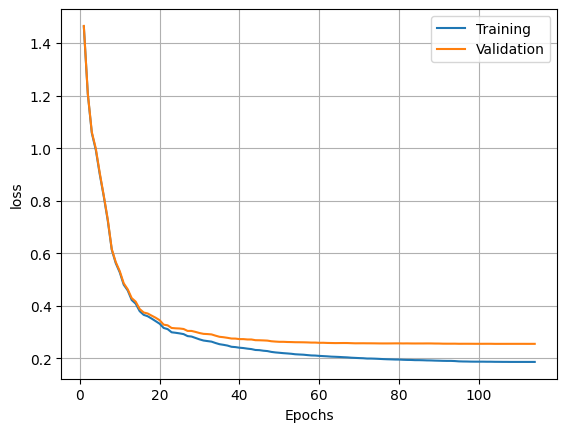

In [37]:
results = clfs[0].evals_result()

train_loss = results['validation_0']['mlogloss']
validation_loss = results['validation_1']['mlogloss']
epochs_grid = np.arange(1, len(train_loss)+1)

plt.plot(epochs_grid, train_loss, label='Training')
plt.plot(epochs_grid, validation_loss, label='Validation')
plt.legend()
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.grid()

Explore results of one of the model previously trained

## 8. Try to improve accuracy using cross validation(혹시나 스태킹이 아닌 보팅을 사용할 경우 이거 사용! / 보팅 알고리즘으로 lgbm, xgb, gb 사용)
In this section we try to improve the accuracy using a voting classifier, consisting of the 3 following algorithms:

- GradientBoosting Classifier
- XGBoost
- LigthGBM

In [73]:
from sklearn.ensemble import VotingClassifier

clf_lgbm = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
clf_xgb = XGBClassifier(**best_params_XGB)
clf_gb = GradientBoostingClassifier()
voting_clf = VotingClassifier(estimators=[('lgbm', clf_lgbm), ('xgb', clf_xgb), ('gb', clf_gb)], 
                              voting='soft')

voting_clf.fit(X, y)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(colsample_bytree=0.22474712453857074,
                                             gamma=0.6667231961547264,
                                             learning_rate=0.02190684141218302,
                                             max_depth=6, min_child_weight=2,
                                             n_estimators=1123,
                                             reg_alpha=0.9923969742306361,
                                             reg_lambda=0.9320510397597621,
                                             subsample=0.6974903495632305,
                                             verbose=-1, verbosity=-1)),
                             ('xgb',
                              XGBClassifier(base_score=None, bo...
                                            interaction_constraints=None,
                                            learning_rate=0.10584250334627063,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None, min_child_weight=0,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=679, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [74]:
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
df_submission['NObeyesdad'] = voting_clf.predict(X_test)
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.set_index('id', inplace=True)

print(df_submission)

df_submission.to_csv('submission.csv')

                NObeyesdad
id                        
20758      Obesity_Type_II
20759   Overweight_Level_I
20760     Obesity_Type_III
20761       Obesity_Type_I
20762     Obesity_Type_III
...                    ...
34593  Overweight_Level_II
34594        Normal_Weight
34595  Insufficient_Weight
34596        Normal_Weight
34597      Obesity_Type_II

[13840 rows x 1 columns]
